In [1]:
import datetime as dt
from app.tinkoff import client, Interval
import pandas as pd

In [2]:
start_dt = dt.datetime(2020, 9, 1, 12, 0)
end_dt = dt.datetime(2020, 9, 7, 12, 0)

candles = list(client.get_candles('BBG000N9MNX3', interval=Interval.H1, start_dt=start_dt, end_dt=end_dt))

tsla_history = pd.DataFrame.from_dict([candle.dict() for candle in candles])
tsla_history

,open,high,low,close,volume,time
0,517,550.0,514,538.64,99660,2020-09-01 12:00:00+05:00
1,538.2,540.0,525.01,535.99,42797,2020-09-01 13:00:00+05:00
2,535.3,535.98,531.04,532.07,9663,2020-09-01 14:00:00+05:00
3,532.07,535.07,528.12,534.99,12920,2020-09-01 15:00:00+05:00
4,535,539,505,510.2,276031,2020-09-01 16:00:00+05:00
...,...,...,...,...,...,...
59,404.88,419,404.18,418.28,2141107,2020-09-04 23:00:00+05:00
60,418.54,426.78,414.12,418,4655155,2020-09-05 00:00:00+05:00
61,417.8,419.44,410.57,417.35,670090,2020-09-05 01:00:00+05:00
62,417.5,422.75,386.7,391.36,899440,2020-09-05 02:00:00+05:00


In [66]:
from app.backtesting import Backtester
from app.trading import MAIntersectionTrader
from app import models

qs = models.Candle.select().where(models.Candle.instrument_id == 1, models.Candle.time >= dt.datetime(2020, 6, 1))

backtester = Backtester.from_db(qs)
trader = MAIntersectionTrader()

In [67]:
trade_history = backtester.run(trader)

100%|██████████| 1100/1100 [00:03<00:00, 295.64it/s]


In [68]:
candles_df = pd.DataFrame.from_dict(candle.dict() for candle in backtester._candles_cache)
candles_df = candles_df[['open', 'time']]

In [69]:
candles_df['price'] = candles_df['open'].shift(-1)
candles_df = candles_df.drop(columns=['open'])

candles_df

,time,price
0,2020-06-01 12:00:00,173.61
1,2020-06-01 13:00:00,171.78
2,2020-06-01 14:00:00,170.75
3,2020-06-01 15:00:00,171.00
4,2020-06-01 16:00:00,171.31
...,...,...
1095,2020-09-04 23:00:00,418.54
1096,2020-09-05 00:00:00,417.80
1097,2020-09-05 01:00:00,417.50
1098,2020-09-05 02:00:00,391.12


In [70]:
trades = candles_df.merge(trade_history.rename('order'), left_on='time', right_index=True)[:-1].reset_index(drop=True)
trades

,time,price,order
0,2020-06-02 16:00:00,178.20,sell
1,2020-06-02 22:00:00,179.20,buy
2,2020-06-02 23:00:00,176.69,sell
3,2020-06-03 12:00:00,177.76,buy
4,2020-06-03 21:00:00,177.46,sell
...,...,...,...
133,2020-09-02 03:00:00,488.37,buy
134,2020-09-02 16:00:00,478.55,sell
135,2020-09-04 15:00:00,399.22,buy
136,2020-09-04 16:00:00,385.64,sell


In [71]:
positions = trades.merge(trades.shift(-1), suffixes=('_enter', '_exit'), left_index=True, right_index=True)[:-1]
positions

,time_enter,price_enter,order_enter,time_exit,price_exit,order_exit
0,2020-06-02 16:00:00,178.20,sell,2020-06-02 22:00:00,179.20,buy
1,2020-06-02 22:00:00,179.20,buy,2020-06-02 23:00:00,176.69,sell
2,2020-06-02 23:00:00,176.69,sell,2020-06-03 12:00:00,177.76,buy
3,2020-06-03 12:00:00,177.76,buy,2020-06-03 21:00:00,177.46,sell
4,2020-06-03 21:00:00,177.46,sell,2020-06-04 13:00:00,176.42,buy
...,...,...,...,...,...,...
132,2020-09-01 17:00:00,501.54,sell,2020-09-02 03:00:00,488.37,buy
133,2020-09-02 03:00:00,488.37,buy,2020-09-02 16:00:00,478.55,sell
134,2020-09-02 16:00:00,478.55,sell,2020-09-04 15:00:00,399.22,buy
135,2020-09-04 15:00:00,399.22,buy,2020-09-04 16:00:00,385.64,sell


In [78]:
from decimal import Decimal

POSITION_FEE = Decimal(0.0005)


def calc_profit_usd(row):
    if row.order_enter == 'buy':
        return float(
            (Decimal(row.price_exit) - Decimal(row.price_exit) * POSITION_FEE) -
            (Decimal(row.price_enter) + Decimal(row.price_enter) * POSITION_FEE)
        )
    else:
        return float(
            (Decimal(row.price_enter) + Decimal(row.price_enter) * POSITION_FEE) -
            (Decimal(row.price_exit) - Decimal(row.price_exit) * POSITION_FEE)
        )
    

def calc_profit_ratio(row):
    if row.order_enter == 'buy':
        return float(
            (Decimal(row.price_exit) - Decimal(row.price_exit) * POSITION_FEE) /
            (Decimal(row.price_enter) + Decimal(row.price_enter) * POSITION_FEE)
        )
    else:
        return float(
            (Decimal(row.price_enter) + Decimal(row.price_enter) * POSITION_FEE) /
            (Decimal(row.price_exit) - Decimal(row.price_exit) * POSITION_FEE)
        )

    
positions['profit_usd'] = positions.apply(calc_profit_usd, axis=1)
positions['profit_ratio'] = positions.apply(calc_profit_ratio, axis=1)
positions

,time_enter,price_enter,order_enter,time_exit,price_exit,order_exit,profit,profit_usd,profit_ratio
0,2020-06-02 16:00:00,178.20,sell,2020-06-02 22:00:00,179.20,buy,0.995415,-0.821300,0.995415
1,2020-06-02 22:00:00,179.20,buy,2020-06-02 23:00:00,176.69,sell,0.985008,-2.687945,0.985008
2,2020-06-02 23:00:00,176.69,sell,2020-06-03 12:00:00,177.76,buy,0.994975,-0.892775,0.994975
3,2020-06-03 12:00:00,177.76,buy,2020-06-03 21:00:00,177.46,sell,0.997315,-0.477610,0.997315
4,2020-06-03 21:00:00,177.46,sell,2020-06-04 13:00:00,176.42,buy,1.006901,1.216940,1.006901
...,...,...,...,...,...,...,...,...,...
132,2020-09-01 17:00:00,501.54,sell,2020-09-02 03:00:00,488.37,buy,1.027995,13.664955,1.027995
133,2020-09-02 03:00:00,488.37,buy,2020-09-02 16:00:00,478.55,sell,0.978913,-10.303460,0.978913
134,2020-09-02 16:00:00,478.55,sell,2020-09-04 15:00:00,399.22,buy,1.199912,79.768885,1.199912
135,2020-09-04 15:00:00,399.22,buy,2020-09-04 16:00:00,385.64,sell,0.965018,-13.972430,0.965018


In [81]:
positions.profit_usd.sum()

244.87412999999998

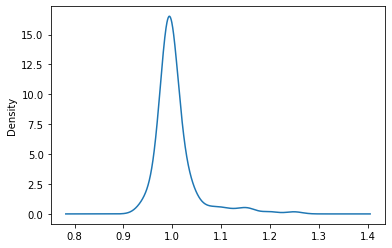

In [84]:
positions.profit_ratio.plot.density()

In [85]:
positions.profit_ratio.describe()

count    137.000000
mean       1.005978
std        0.044149
min        0.937742
25%        0.988443
50%        0.995511
75%        1.005398
max        1.249290
Name: profit_ratio, dtype: float64